In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tcn import TCN

df = pd.read_csv("tmp_df_data.csv")


# --- 1) PREPROCESSING -------------------------------------------------------

# split train vs test by SPLIT column
train_df = df[df['SPLIT']=='train'].copy()
test_df  = df[df['SPLIT']=='test'].copy()

# numeric & categorical columns
num_cols = ['Close','Volume','Return','Risk','RSI','ADX',
            'MOM','HL','HO','LO','buy_pressure_ratio',
            'trades_per_volume','slope']
cat_col  = ['F&G category']

# one‐hot encode category
oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oh_train = oh.fit_transform(train_df[cat_col])
oh_test  = oh.transform(test_df[cat_col])
cat_feats = oh.get_feature_names_out(cat_col)

# build feature matrices
X_train_raw = np.hstack([train_df[num_cols].values, oh_train])
X_test_raw  = np.hstack([test_df[num_cols].values,  oh_test ])
feature_names = num_cols + list(cat_feats)

# standard scale
scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# extract scaled return for target
ret_idx = feature_names.index('Return')
y_train = X_train[:, ret_idx]
y_test  = X_test[:,  ret_idx]

# keep previous-day prices to reconstruct later
prices = pd.concat([train_df['Close'], test_df['Close']]).values
prev_train = prices[1:len(y_train)+1]
prev_test  = prices[len(train_df)+1:len(train_df)+1+len(y_test)]
true_train = prices[1:len(y_train)+1]
true_test  = prices[len(train_df)+1:len(train_df)+1+len(y_test)]

# --- 2) MAKE SEQUENCES ------------------------------------------------------

def make_seqs(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 30
X_tr, y_tr = make_seqs(X_train, y_train, seq_len=SEQ_LEN)
X_te, y_te = make_seqs(X_test,  y_test,  seq_len=SEQ_LEN)

# adjust price arrays to align
prev_train = prev_train[SEQ_LEN:]
true_train = true_train[SEQ_LEN:]
prev_test  = prev_test[SEQ_LEN:]
true_test  = true_test[SEQ_LEN:]

# --- 3) OPTUNA TUNING -------------------------------------------------------

def objective(trial):
    filters   = trial.suggest_int("filters", 32, 128, step=32)
    kernel    = trial.suggest_int("kernel_size", 2, 5)
    dp        = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr        = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    bs        = trial.suggest_categorical("batch_size", [32,64,128])
    
    model = Sequential([
        Input(shape=X_tr.shape[1:]),
        TCN(nb_filters=filters, kernel_size=kernel, dilations=[1,2,4], 
            return_sequences=False, dropout_rate=dp),
        Dropout(dp),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(lr), loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_te, y_te),
        epochs=50,
        batch_size=bs,
        callbacks=[es],
        verbose=0
    )
    return min(history.history['val_loss'])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_trial.params)

# --- 4) TRAIN FINAL ---------------------------------------------------------

best = study.best_trial.params
model = Sequential([
    Input(shape=X_tr.shape[1:]),
    TCN(nb_filters=best['filters'],
        kernel_size=best['kernel_size'],
        dilations=[1,2,4],
        return_sequences=False,
        dropout_rate=best['dropout']),
    Dropout(best['dropout']),
    Dense(1, activation='linear')
])
model.compile(optimizer=Adam(best['lr']), loss='mse')
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=50,
    batch_size=best['batch_size'],
    callbacks=[es],
    verbose=1
)


[I 2025-05-04 17:57:11,913] A new study created in memory with name: no-name-dedd779e-e1b8-48de-9c24-fd29298a17d9


[I 2025-05-04 17:57:25,370] Trial 0 finished with value: 1.012634515762329 and parameters: {'filters': 32, 'kernel_size': 4, 'dropout': 0.5, 'lr': 0.00015352751994485704, 'batch_size': 64}. Best is trial 0 with value: 1.012634515762329.
[I 2025-05-04 17:57:46,088] Trial 1 finished with value: 0.565645158290863 and parameters: {'filters': 96, 'kernel_size': 5, 'dropout': 0.5, 'lr': 0.000292079929637091, 'batch_size': 64}. Best is trial 1 with value: 0.565645158290863.
[I 2025-05-04 17:58:03,779] Trial 2 finished with value: 1.2937572002410889 and parameters: {'filters': 96, 'kernel_size': 2, 'dropout': 0.4, 'lr': 0.00015756554508681997, 'batch_size': 128}. Best is trial 1 with value: 0.565645158290863.
[I 2025-05-04 17:58:17,937] Trial 3 finished with value: 0.8217536807060242 and parameters: {'filters': 128, 'kernel_size': 2, 'dropout': 0.1, 'lr': 0.0007551987387537226, 'batch_size': 64}. Best is trial 1 with value: 0.565645158290863.
[I 2025-05-04 17:58:43,732] Trial 4 finished with v

Best params: {'filters': 64, 'kernel_size': 3, 'dropout': 0.30000000000000004, 'lr': 0.0015590423445178316, 'batch_size': 32}
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 29.9535 - val_loss: 2.2163
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5977 - val_loss: 1.0187
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9087 - val_loss: 0.7977
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7541 - val_loss: 0.7018
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5702 - val_loss: 0.6345
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2850 - val_loss: 0.6212
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2506 - val_loss: 0.5997
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0179 - val_loss: 0.5672
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2144 - val_loss: 0.5538
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3658 - val_loss: 0.5398
Epoch 11/50
47/47 ━━━━━━━━━━━━━

ValueError: operands could not be broadcast together with shapes (350,) (351,) 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


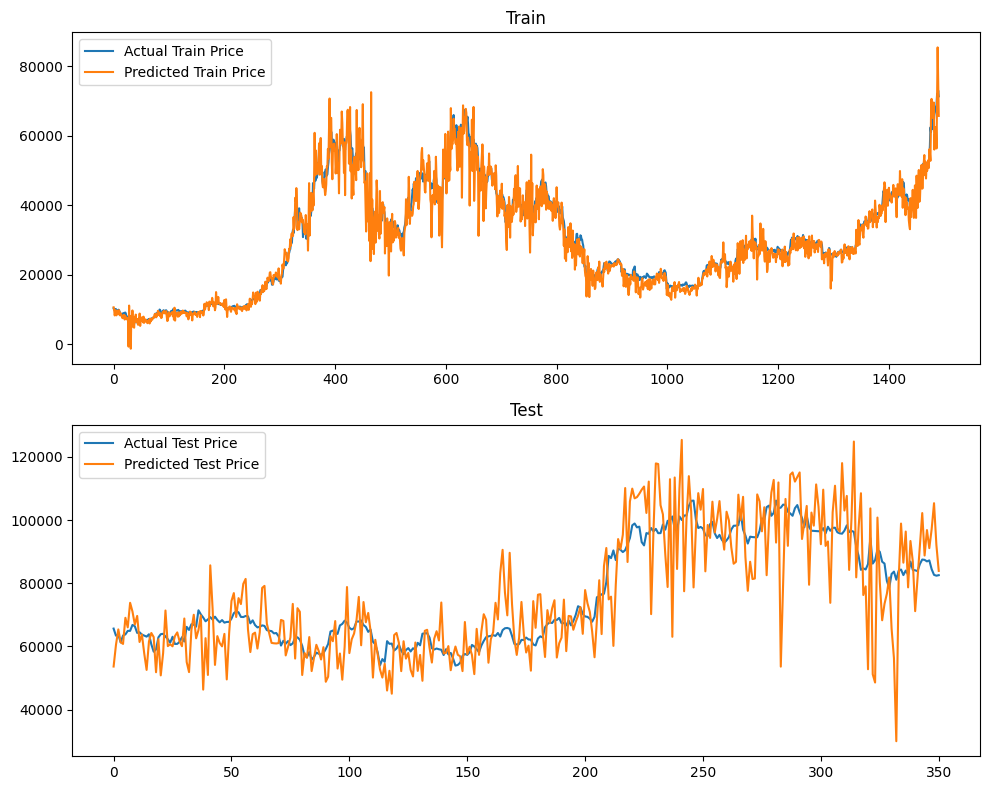

Train MSE – Model: 12582445.86, Naïve: 1429209.63
 Test MSE – Model: 122656649.33, Naïve: 4013949.55


In [20]:

# --- 5) PREDICT & RECONSTRUCT PRICES ----------------------------------------

# … after make_seqs …
X_tr, y_tr = make_seqs(X_train, y_train, seq_len=SEQ_LEN)
X_te, y_te = make_seqs(X_test,  y_test,  seq_len=SEQ_LEN)

# Rebuild raw price arrays to match sequence windows
train_close = train_df['Close'].values
test_close  = test_df['Close'].values

prev_train = train_close[SEQ_LEN-1:-1]
true_train = train_close[SEQ_LEN:   ]

prev_test  = test_close[SEQ_LEN-1:-1]
true_test  = test_close[SEQ_LEN:   ]

# … then later …
r_tr = model.predict(X_tr).flatten()
r_te = model.predict(X_te).flatten()

p_tr_pred = prev_train * (1 + r_tr)
p_te_pred = prev_test  * (1 + r_te)


# --- 6) PLOT ----------------------------------------------------------------

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
ax1.plot(true_train, label='Actual Train Price')
ax1.plot(p_tr_pred,  label='Predicted Train Price')
ax1.legend(); ax1.set_title("Train")
ax2.plot(true_test, label='Actual Test Price')
ax2.plot(p_te_pred,  label='Predicted Test Price')
ax2.legend(); ax2.set_title("Test")
plt.tight_layout(); plt.show()

# --- 7) MSE COMPARISON -------------------------------------------------------

mse_model_tr = mean_squared_error(true_train, p_tr_pred)
mse_model_te = mean_squared_error(true_test,  p_te_pred)
mse_naive_tr = mean_squared_error(true_train, prev_train)
mse_naive_te = mean_squared_error(true_test,  prev_test)

print(f"Train MSE – Model: {mse_model_tr:.2f}, Naïve: {mse_naive_tr:.2f}")
print(f" Test MSE – Model: {mse_model_te:.2f}, Naïve: {mse_naive_te:.2f}")
